In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import time

from stance_leg_controller import ForceStanceLegController

from quadruped_jax import QuadrupedQPProjector

import matplotlib.pyplot as plt

In [2]:
num_batch=10  # Increased batch size to demonstrate batching
maxiter=200
rho=1.0
desired_speed=(0.0, 0.0)
desired_twisting_speed=0.0
desired_body_height=0.5
body_mass=50.0
body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
num_legs=4
friction_coeff=0.2
timestep=0.05
horizon=100
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

In [3]:
# Initialize the projector with organized parameters
projector = QuadrupedQPProjector(
    num_batch=num_batch,
    maxiter=maxiter,
    rho=rho,
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    foot_x=foot_x,
    foot_y=foot_y,
    foot_z=foot_z
)
    

self.num_total_constraints 2400
self.A_eq.shape (300, 1200)
self.b_eq.shape (10, 300)


In [4]:
# Print problem information
projector.print_problem_info()

# Sample batched initial guess
key = jax.random.PRNGKey(42)


lamda_init = jnp.zeros((projector.num_batch, projector.nvar))

#print(f"Initial xi batch shape: {xi_init.shape}")
print(f"Initial lambda batch shape: {lamda_init.shape}")

xi_init = jnp.zeros((projector.num_batch, projector.nvar))
# for i in range(4*projector.horizon):
#     xi_init[:, 3*i+2] == body_mass*9.81/4.0

=== Quadruped QP Problem Information ===
H matrix shape: (1200, 1200)
g vector shape: (1200,)
C matrix shape: (2400, 1200)
constraint limit vector shape: (2400,)
Number of variables: 1200
Number of constraints: 2400
Batch size: 10
Max iterations: 200
ADMM penalty (rho): 1.0
Initial lambda batch shape: (10, 1200)


In [5]:
# Solve batched QP projection
start_time = time.time()
xi_proj, primal_residual, fixed_point_residual = projector.compute_qp_projection(xi_init, lamda_init)
solve_time = time.time() - start_time

In [6]:
print(f"\n=== Solution Results ===")
print(f"Projection time: {solve_time:.6f} seconds")
print(f"Projected xi batch shape: {xi_proj.shape}")
print(f"Final primal residual shape: {primal_residual[-1].shape}")
print(f"Final dual residual shape: {fixed_point_residual[-1].shape}")

# Display convergence statistics
primal_residual_np = np.array(primal_residual)
fixed_point_residual_np = np.array(fixed_point_residual)

print(f"\n=== Convergence Statistics ===")
print(f"Primal residual - Initial (mean): {np.mean(primal_residual_np[0]):.6f}, Final (mean): {np.mean(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Initial (mean): {np.mean(fixed_point_residual_np[0]):.6f}, Final (mean): {np.mean(fixed_point_residual_np[-1]):.6f}")
print(f"Primal residual - Final (max): {np.max(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Final (max): {np.max(fixed_point_residual_np[-1]):.6f}")

# Extract force outputs (first 12 elements as in original code) for all batches
force_output = -xi_proj[:, :12]
print(f"\n=== Force Output ===")
print(f"Projected forces batch shape: {force_output.shape}")
print(f"First batch projected forces: {force_output[0]}")

print("\nBatched Quadruped QP projection complete!")


=== Solution Results ===
Projection time: 2.172315 seconds
Projected xi batch shape: (10, 1200)
Final primal residual shape: (10,)
Final dual residual shape: (10,)

=== Convergence Statistics ===
Primal residual - Initial (mean): 0.000000, Final (mean): 0.000000
Dual residual - Initial (mean): 5024.423340, Final (mean): 0.268326
Primal residual - Final (max): 0.000000
Dual residual - Final (max): 0.268326

=== Force Output ===
Projected forces batch shape: (10, 12)
First batch projected forces: [ 2.92432446e-06  5.28630198e-06 -1.22663780e+02  4.06369418e-06
  5.19014475e-06 -1.22663795e+02  2.26289080e-06  3.16947921e-06
 -1.22586281e+02  1.19149388e-06  5.16316049e-06 -1.22586235e+02]

Batched Quadruped QP projection complete!


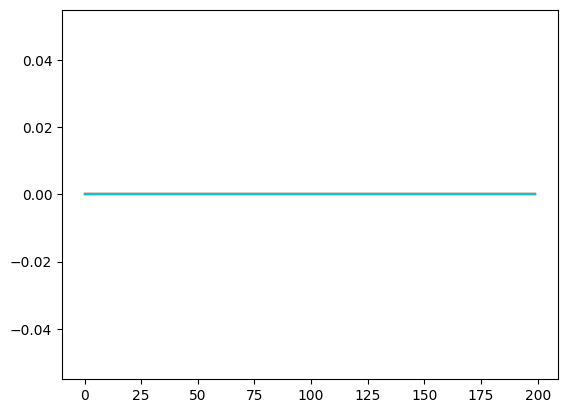

In [7]:
%matplotlib inline
plt.figure()
plt.plot(primal_residual)
plt.show()

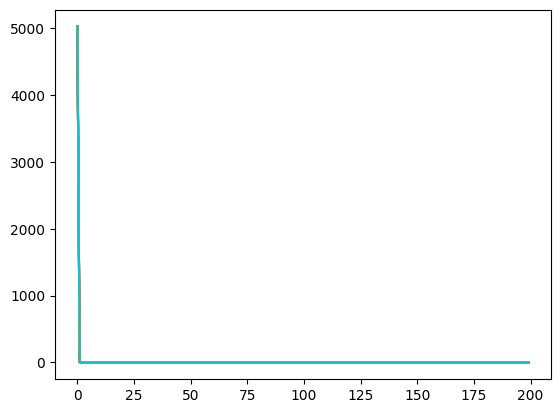

In [8]:
%matplotlib inline
plt.figure()
plt.plot(fixed_point_residual)
plt.show()

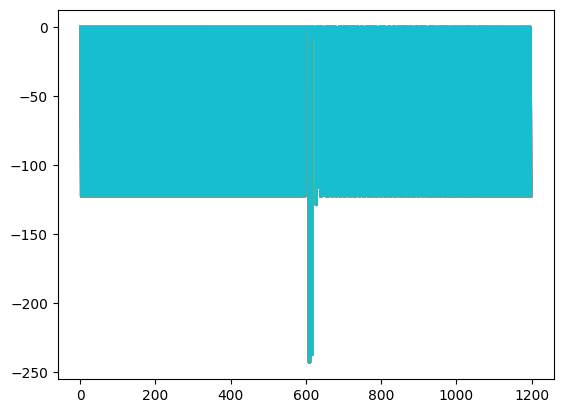

In [9]:
%matplotlib inline
plt.figure()
plt.plot(-xi_proj.T)
plt.show()